In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
import pandas
od.download(
	"https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: karthikvarma56
Your Kaggle Key: ··········


100%|██████████| 5.20G/5.20G [00:52<00:00, 106MB/s] 


In [4]:
import numpy as np
import tensorflow as tf
import PIL
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [5]:
def plot_Model_lossAcc(his):
    plt.figure(figsize = (16,8))

    plt.subplot(2,2,1)
    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    plt.figure(figsize = (16,8))

    plt.subplot(2,2,2)
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [6]:
path = '/content/skin-cancer-mnist-ham10000/'
p1 = 'HAM10000_images_part_1/'
p2 = 'HAM10000_images_part_2/'
meta = 'HAM10000_metadata.csv'

In [7]:
cancer_df = pd.read_csv(path+meta)

In [8]:
print(cancer_df['dx'].unique())
classnames = cancer_df['dx'].unique()
separate_dict = {}

for unique_class in classnames:
    temp = cancer_df.loc[cancer_df['dx'] == unique_class,['image_id']]
    separate_dict[unique_class] = temp['image_id'].tolist()
print(separate_dict.keys())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
dict_keys(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'])


In [9]:
name = [(os.listdir(path + x)) for x in os.listdir(path) if os.path.isdir(path + x)]
name.remove(name[3])
name.remove(name[1])
all_names = name[0]+name[1]
all_path = [path+p1+x for x in name[0]]+[path+p2+x for x in name[1]]

In [10]:
# Generate one hot encodings for all classes
encoder_keys = list(separate_dict.keys())
encoder_template = {}
for i in encoder_keys:
    if i == 'bkl':
        encoder_template[i] = [1,0,0,0,0,0,0]
    elif i == 'nv':
        encoder_template[i] = [0,1,0,0,0,0,0]
    elif i == 'df':
        encoder_template[i] = [0,0,1,0,0,0,0]
    elif i == 'mel':
        encoder_template[i] = [0,0,0,1,0,0,0]
    elif i == 'vasc':
        encoder_template[i] = [0,0,0,0,1,0,0]
    elif i == 'bcc':
        encoder_template[i] = [0,0,0,0,0,1,0]
    elif i == 'akiec':
        encoder_template[i] = [0,0,0,0,0,0,1]

print(encoder_template)

{'bkl': [1, 0, 0, 0, 0, 0, 0], 'nv': [0, 1, 0, 0, 0, 0, 0], 'df': [0, 0, 1, 0, 0, 0, 0], 'mel': [0, 0, 0, 1, 0, 0, 0], 'vasc': [0, 0, 0, 0, 1, 0, 0], 'bcc': [0, 0, 0, 0, 0, 1, 0], 'akiec': [0, 0, 0, 0, 0, 0, 1]}


In [11]:
# Generate one hot encodings
all_encodings = []
for img_name in all_names:
    temp1 = img_name.split('.')
    if temp1[0] in separate_dict['bkl']:
        all_encodings.append(encoder_template['bkl'])

    elif temp1[0] in separate_dict['nv']:
        all_encodings.append(encoder_template['nv'])

    elif temp1[0] in separate_dict['df']:
        all_encodings.append(encoder_template['df'])

    elif temp1[0] in separate_dict['mel']:
        all_encodings.append(encoder_template['mel'])

    elif temp1[0] in separate_dict['vasc']:
        all_encodings.append(encoder_template['vasc'])

    elif temp1[0] in separate_dict['bcc']:
        all_encodings.append(encoder_template['bcc'])

    elif temp1[0] in separate_dict['akiec']:
        all_encodings.append(encoder_template['akiec'])

print(len(all_encodings))

10015


In [12]:
# Assign one hot encodings to all the image paths in sync
all_path_encodings = list(zip(all_path,all_encodings))
random.shuffle(all_path_encodings)
all_path,all_encodings = zip(*all_path_encodings)

print(all_path_encodings[0])

('/content/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0030803.jpg', [0, 0, 0, 0, 0, 0, 1])


In [13]:
data_pipeline = tf.data.Dataset.from_tensor_slices((list(all_path),list(all_encodings)))

In [14]:
del all_path, all_encodings, all_path_encodings, all_names, name, separate_dict, encoder_keys, encoder_template, classnames, cancer_df
gc.collect()

43

In [15]:
def load_images_and_process(image_path,one_hot_vec):
    '''load images and decode jpeg'''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
#     return image,one_hot_vec

# def process_image(image,one_hot_vec):
    '''normalise from 0-255 to 0-1'''
#     image = tf.cast(image, tf.float16) / 255.0
    image = tf.image.resize(image, [90,120])
    image = image/255
    return image,one_hot_vec

In [16]:
data_pipeline = data_pipeline.map(load_images_and_process).prefetch(tf.data.AUTOTUNE)#.map(process_image)

In [17]:
# Train, test, validation split
train_size = int(0.8*len(data_pipeline))
val_size = int(0.1*len(data_pipeline))
test_size =int(len(data_pipeline)) - train_size - val_size
print(len(data_pipeline),train_size,val_size,test_size)

train_ds = data_pipeline.take(train_size)
val_ds = data_pipeline.take(val_size)
test_ds = data_pipeline.take(test_size)


train_ds = train_ds.shuffle(10000)
val_ds = val_ds.shuffle(1000)
test_ds = test_ds.shuffle(1000)

10015 8012 1001 1002


In [18]:
print(len(val_ds),len(train_ds),len(test_ds))
del data_pipeline
gc.collect()

1001 8012 1002


0

In [19]:
# Model building

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(30, (5,5),strides = (1,1), padding = 'valid', activation = 'relu', input_shape = (90,120, 3)))
# model.add(tf.keras.layers.Conv2D(32, (3,3),strides = (1,1), padding = 'valid', activation = 'relu', input_shape = (32,32,2)))
model.add(tf.keras.layers.Conv2D(30,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))

model.add(tf.keras.layers.Conv2D(20,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Conv2D(15,(3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))
# model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(15, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.GroupNormalization(groups=3))
# model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))

# model.add(tf.keras.layers.Conv2D(8, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(8, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))
# # model.add(tf.keras.layers.Conv2D(6, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=8))

# model.add(tf.keras.layers.Conv2D(6, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=6))

model.add(tf.keras.layers.Conv2D(10, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.GroupNormalization(groups=6))

# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(64, (3,3),strides = (1,1), padding = 'valid', activation = 'relu'))

# model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = None, padding = 'valid'))
# model.add(tf.keras.layers.Conv2D(8,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
# model.add(tf.keras.layers.Conv2D(4,(3,3), strides = (1,1), padding = 'valid', activation = 'relu'))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Normalization())
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Dense(1024,activation = 'relu'))
model.add(tf.keras.layers.Dense(256,activation = 'relu'))

# model.add(tf.keras.layers.LayerNormalization())
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128,activation = 'relu'))
# model.add(tf.keras.layers.Normalization())

# model.add(tf.keras.layers.Dense(64,activation = 'relu'))
# model.add(tf.keras.layers.Normalization())

# model.add(tf.keras.layers.Dense(128,activation = 'relu'))

model.add(tf.keras.layers.Dense(7,activation = 'softmax'))

In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 116, 30)       2280      
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 114, 30)       8130      
                                                                 
 batch_normalization (BatchN  (None, 84, 114, 30)      120       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 57, 30)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 55, 20)        5420      
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 53, 15)        2

In [22]:
epochs = 20
batch_size = 8

checkpoint_filepath = '/content/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy')
EarlyStop = tf.keras.callbacks.EarlyStopping(monitor='EarlyStopping', patience=5)
def scheduler(epoch, lr):
    flr = 1e-3
    if epoch < epochs*0.1 :
        return flr
    elif epoch > epochs*0.1 and epoch < epochs*0.25:
        lr *= tf.math.exp(-0.1)
        return lr
    else:
        lr *= tf.math.exp(-0.008)
#         return lr * tf.math.exp(-0.004)
        return lr
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Memory clear on every epoch
class MemoryClearCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
memory_clear_callback = MemoryClearCallback()

In [23]:
history = model.fit(train_ds.batch(batch_size),epochs=epochs,validation_data=val_ds.batch(batch_size),callbacks=[model_checkpoint_callback,EarlyStop,memory_clear_callback],shuffle=True)

Epoch 1/20
1002/1002 [==============================] - ETA: 0s - loss: 1.0586 - accuracy: 0.6505

1002/1002 [==============================] - 463s 391ms/step - loss: 1.0586 - accuracy: 0.6505 - val_loss: 1.4215 - val_accuracy: 0.4625
Epoch 2/20
1002/1002 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.6680

1002/1002 [==============================] - 442s 391ms/step - loss: 0.9590 - accuracy: 0.6680 - val_loss: 1.3357 - val_accuracy: 0.4605
Epoch 3/20
1002/1002 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.6840

1002/1002 [==============================] - 436s 384ms/step - loss: 0.8889 - accuracy: 0.6840 - val_loss: 1.1633 - val_accuracy: 0.5764
Epoch 4/20
1002/1002 [==============================] - ETA: 0s - loss: 0.8325 - accuracy: 0.6985

1002/1002 [==============================] - 440s 391ms/step - loss: 0.8325 - accuracy: 0.6985 - val_loss: 0.7867 - val_accuracy: 0.7253
Epoch 5/20
1002/1002 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.7079

1002/1002 [==============================] - 437s 384ms/step - loss: 0.8103 - accuracy: 0.7079 - val_loss: 0.8409 - val_accuracy: 0.7063
Epoch 6/20
1002/1002 [==============================] - ETA: 0s - loss: 0.7858 - accuracy: 0.7149

1002/1002 [==============================] - 435s 384ms/step - loss: 0.7858 - accuracy: 0.7149 - val_loss: 0.9741 - val_accuracy: 0.6933
Epoch 7/20
1002/1002 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.7208

1002/1002 [==============================] - 444s 393ms/step - loss: 0.7571 - accuracy: 0.7208 - val_loss: 0.7142 - val_accuracy: 0.7263
Epoch 8/20
1002/1002 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.7353

1002/1002 [==============================] - 431s 380ms/step - loss: 0.7294 - accuracy: 0.7353 - val_loss: 0.8736 - val_accuracy: 0.6833
Epoch 9/20
1002/1002 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7368

1002/1002 [==============================] - 437s 386ms/step - loss: 0.7121 - accuracy: 0.7368 - val_loss: 0.7670 - val_accuracy: 0.7273
Epoch 10/20
1002/1002 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7494

1002/1002 [==============================] - 433s 381ms/step - loss: 0.6746 - accuracy: 0.7494 - val_loss: 1.9904 - val_accuracy: 0.6653
Epoch 11/20
1002/1002 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.7504

1002/1002 [==============================] - 441s 384ms/step - loss: 0.6727 - accuracy: 0.7504 - val_loss: 0.7881 - val_accuracy: 0.7033
Epoch 12/20
1002/1002 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7490

1002/1002 [==============================] - 433s 382ms/step - loss: 0.6879 - accuracy: 0.7490 - val_loss: 0.7094 - val_accuracy: 0.7353
Epoch 13/20
1002/1002 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.7742

1002/1002 [==============================] - 438s 381ms/step - loss: 0.6217 - accuracy: 0.7742 - val_loss: 0.7055 - val_accuracy: 0.7512
Epoch 14/20
1002/1002 [==============================] - ETA: 0s - loss: 0.5730 - accuracy: 0.7903

1002/1002 [==============================] - 437s 386ms/step - loss: 0.5730 - accuracy: 0.7903 - val_loss: 0.4726 - val_accuracy: 0.8182
Epoch 15/20
1002/1002 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.8089

1002/1002 [==============================] - 446s 394ms/step - loss: 0.5135 - accuracy: 0.8089 - val_loss: 0.5095 - val_accuracy: 0.7972
Epoch 16/20
1002/1002 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.8152

1002/1002 [==============================] - 433s 382ms/step - loss: 0.5008 - accuracy: 0.8152 - val_loss: 0.5736 - val_accuracy: 0.8102
Epoch 17/20
1002/1002 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8281

1002/1002 [==============================] - 445s 386ms/step - loss: 0.4715 - accuracy: 0.8281 - val_loss: 0.6086 - val_accuracy: 0.7842
Epoch 18/20
1002/1002 [==============================] - ETA: 0s - loss: 0.3949 - accuracy: 0.8537

1002/1002 [==============================] - 436s 386ms/step - loss: 0.3949 - accuracy: 0.8537 - val_loss: 0.4420 - val_accuracy: 0.8342
Epoch 19/20
1002/1002 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.8733

1002/1002 [==============================] - 437s 386ms/step - loss: 0.3484 - accuracy: 0.8733 - val_loss: 0.6016 - val_accuracy: 0.8232
Epoch 20/20
1002/1002 [==============================] - ETA: 0s - loss: 0.3305 - accuracy: 0.8817

1002/1002 [==============================] - 441s 384ms/step - loss: 0.3305 - accuracy: 0.8817 - val_loss: 0.1470 - val_accuracy: 0.9451


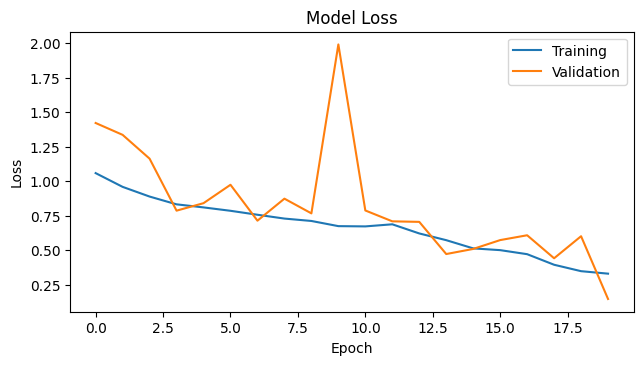

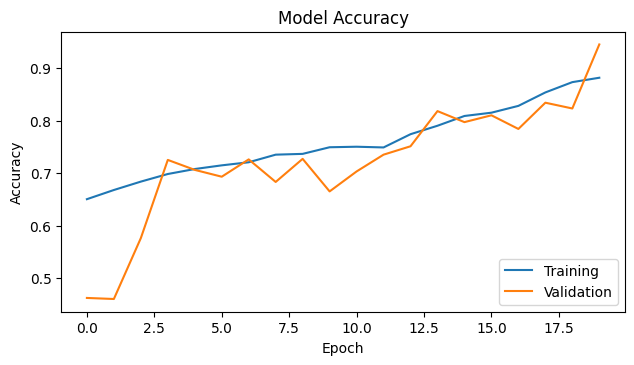

In [24]:
plot_Model_lossAcc(history)

In [ ]:
import shutil
shutil.make_archive('recentbestmo', 'zip', '/content')